# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

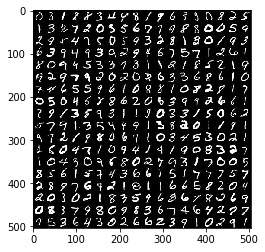

In [2]:
show_n_images = 350

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

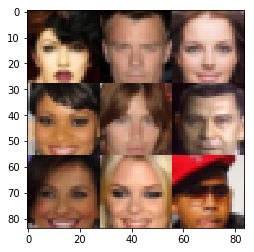

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learning_rate_placeholder = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Double from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learning_rate_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learning_rate_placeholder: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 1.8636
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.4677
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 3.3983
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 1.3724
Epoch 1/2... Discriminator Loss: 0.7137... Generator Loss: 1.8704
Epoch 1/2... Discriminator Loss: 0.7022... Generator Loss: 1.1223
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 1.9181
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.5999


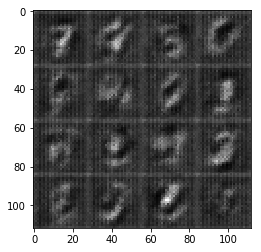

Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 1.1624
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 1.1644
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.6987
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 1.4584
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.4037
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 2.6630
Epoch 1/2... Discriminator Loss: 0.6813... Generator Loss: 1.9771
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 0.9146


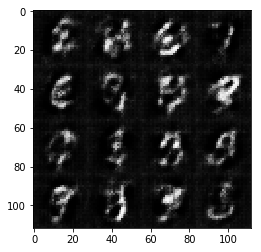

Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 3.1859
Epoch 1/2... Discriminator Loss: 0.6513... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 0.7720... Generator Loss: 2.4048
Epoch 1/2... Discriminator Loss: 0.5664... Generator Loss: 1.6939
Epoch 1/2... Discriminator Loss: 0.6497... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 0.5409... Generator Loss: 1.4180
Epoch 1/2... Discriminator Loss: 0.4743... Generator Loss: 1.6131
Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 1.7348
Epoch 1/2... Discriminator Loss: 0.4625... Generator Loss: 1.6265


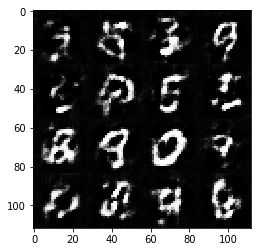

Epoch 1/2... Discriminator Loss: 0.4924... Generator Loss: 1.5671
Epoch 1/2... Discriminator Loss: 0.6303... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 0.7503... Generator Loss: 3.4126
Epoch 1/2... Discriminator Loss: 0.4573... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 0.3450... Generator Loss: 2.3708
Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 1.9084
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 2.2731
Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 2.1087
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 1.3522


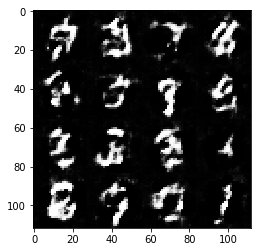

Epoch 1/2... Discriminator Loss: 0.3302... Generator Loss: 2.4362
Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 1.5825
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 2.6005
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 4.1422
Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 2.1905
Epoch 1/2... Discriminator Loss: 0.4471... Generator Loss: 2.2539
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 1.8020
Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 1.2588
Epoch 1/2... Discriminator Loss: 0.7407... Generator Loss: 0.8880


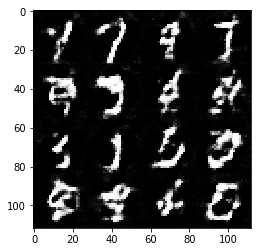

Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 1.8119
Epoch 1/2... Discriminator Loss: 0.4567... Generator Loss: 1.7101
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 0.5310... Generator Loss: 2.5170
Epoch 1/2... Discriminator Loss: 0.6581... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 0.6370... Generator Loss: 1.6817
Epoch 1/2... Discriminator Loss: 0.4981... Generator Loss: 1.9555
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 1.2355
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 0.5286... Generator Loss: 1.3116


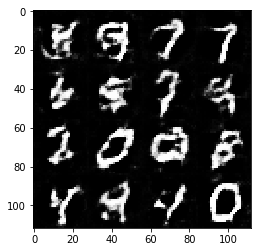

Epoch 1/2... Discriminator Loss: 0.5599... Generator Loss: 1.1681
Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 1.2516
Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 2.0101
Epoch 1/2... Discriminator Loss: 0.4556... Generator Loss: 1.5418
Epoch 1/2... Discriminator Loss: 0.5532... Generator Loss: 1.8615
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 2.5954
Epoch 1/2... Discriminator Loss: 0.4458... Generator Loss: 1.7076
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 1.6833
Epoch 1/2... Discriminator Loss: 0.5849... Generator Loss: 1.2036


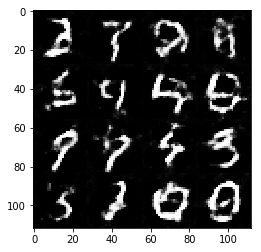

Epoch 1/2... Discriminator Loss: 0.4293... Generator Loss: 1.7264
Epoch 1/2... Discriminator Loss: 0.5319... Generator Loss: 1.1672
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 1.7994
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 1.2018
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 1.1193
Epoch 1/2... Discriminator Loss: 0.5599... Generator Loss: 1.7315
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 1.3860
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 2.4982
Epoch 1/2... Discriminator Loss: 0.9147... Generator Loss: 0.6991


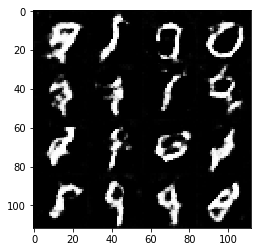

Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 2.2348
Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 2.3432
Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 1.6082
Epoch 1/2... Discriminator Loss: 1.7905... Generator Loss: 0.3037
Epoch 1/2... Discriminator Loss: 0.6855... Generator Loss: 1.0007
Epoch 1/2... Discriminator Loss: 0.4529... Generator Loss: 1.4763
Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 1.5140
Epoch 1/2... Discriminator Loss: 0.7775... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 1.7446


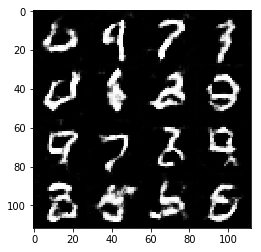

Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 1.1217
Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 2.4450
Epoch 1/2... Discriminator Loss: 0.4069... Generator Loss: 2.2589
Epoch 2/2... Discriminator Loss: 0.2952... Generator Loss: 2.3092
Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 1.9567
Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.5357
Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 2.2978
Epoch 2/2... Discriminator Loss: 1.8521... Generator Loss: 3.7817
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 0.5763... Generator Loss: 1.5628


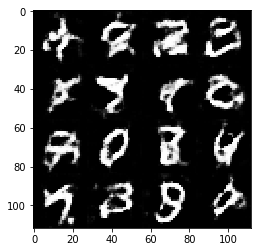

Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 1.9655
Epoch 2/2... Discriminator Loss: 0.4644... Generator Loss: 1.4841
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 0.4134... Generator Loss: 1.5479
Epoch 2/2... Discriminator Loss: 0.4417... Generator Loss: 1.4883
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.1844
Epoch 2/2... Discriminator Loss: 0.7804... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 0.4166... Generator Loss: 1.7341
Epoch 2/2... Discriminator Loss: 0.3279... Generator Loss: 2.0854
Epoch 2/2... Discriminator Loss: 0.4551... Generator Loss: 1.4691


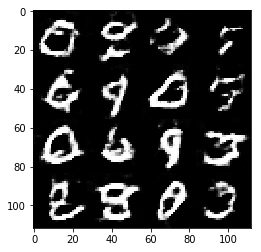

Epoch 2/2... Discriminator Loss: 0.4923... Generator Loss: 1.3384
Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 1.6318
Epoch 2/2... Discriminator Loss: 0.4556... Generator Loss: 2.9598
Epoch 2/2... Discriminator Loss: 0.4979... Generator Loss: 1.2974
Epoch 2/2... Discriminator Loss: 0.3052... Generator Loss: 2.1911
Epoch 2/2... Discriminator Loss: 0.5327... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 4.9792
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.0245
Epoch 2/2... Discriminator Loss: 0.3616... Generator Loss: 2.0365
Epoch 2/2... Discriminator Loss: 0.5592... Generator Loss: 1.1503


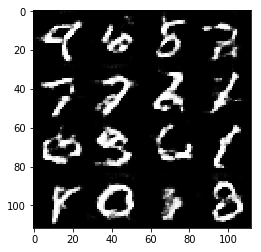

Epoch 2/2... Discriminator Loss: 0.4663... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 0.3593... Generator Loss: 1.6150
Epoch 2/2... Discriminator Loss: 0.5258... Generator Loss: 1.2665
Epoch 2/2... Discriminator Loss: 0.3464... Generator Loss: 2.0098
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 0.4690... Generator Loss: 1.4627
Epoch 2/2... Discriminator Loss: 0.3017... Generator Loss: 1.7776
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 1.5754
Epoch 2/2... Discriminator Loss: 0.5252... Generator Loss: 1.1886


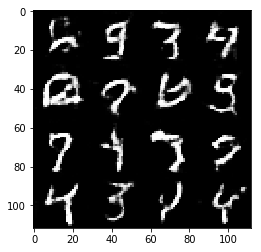

Epoch 2/2... Discriminator Loss: 0.4459... Generator Loss: 1.4683
Epoch 2/2... Discriminator Loss: 0.3691... Generator Loss: 1.6247
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 1.2146
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 0.8375
Epoch 2/2... Discriminator Loss: 0.3179... Generator Loss: 1.7297
Epoch 2/2... Discriminator Loss: 0.4687... Generator Loss: 1.4295
Epoch 2/2... Discriminator Loss: 0.5053... Generator Loss: 1.1877
Epoch 2/2... Discriminator Loss: 0.4032... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.1016
Epoch 2/2... Discriminator Loss: 0.4046... Generator Loss: 1.4569


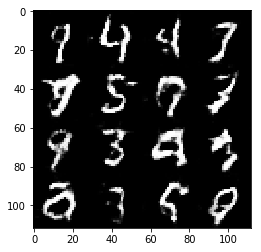

Epoch 2/2... Discriminator Loss: 0.3293... Generator Loss: 1.7120
Epoch 2/2... Discriminator Loss: 0.3447... Generator Loss: 1.7348
Epoch 2/2... Discriminator Loss: 0.3815... Generator Loss: 1.5011
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 1.1226
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 1.6189
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.7099
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 2.3777
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.4071
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 0.8583


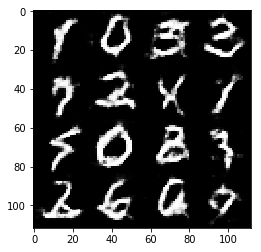

Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.4381
Epoch 2/2... Discriminator Loss: 0.4478... Generator Loss: 1.8134
Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.3829
Epoch 2/2... Discriminator Loss: 0.4560... Generator Loss: 1.4417
Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 1.7160
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.6583
Epoch 2/2... Discriminator Loss: 0.4990... Generator Loss: 2.1956
Epoch 2/2... Discriminator Loss: 0.4872... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 0.4290... Generator Loss: 1.4704


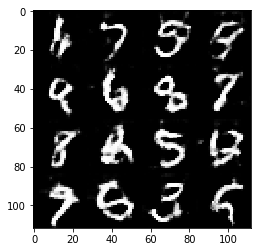

Epoch 2/2... Discriminator Loss: 0.5200... Generator Loss: 1.1787
Epoch 2/2... Discriminator Loss: 0.3156... Generator Loss: 1.8314
Epoch 2/2... Discriminator Loss: 0.4062... Generator Loss: 1.4373
Epoch 2/2... Discriminator Loss: 0.5666... Generator Loss: 1.0834
Epoch 2/2... Discriminator Loss: 0.3233... Generator Loss: 1.7108
Epoch 2/2... Discriminator Loss: 0.3734... Generator Loss: 1.7780
Epoch 2/2... Discriminator Loss: 0.4328... Generator Loss: 1.3337
Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 1.5890
Epoch 2/2... Discriminator Loss: 0.5008... Generator Loss: 1.1845
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.0573


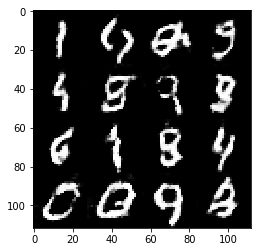

Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 1.1703
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 0.9521
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 0.5867
Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 0.3733... Generator Loss: 1.5271
Epoch 2/2... Discriminator Loss: 0.4566... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 0.5214... Generator Loss: 1.0979
Epoch 2/2... Discriminator Loss: 0.3019... Generator Loss: 1.7709
Epoch 2/2... Discriminator Loss: 0.3745... Generator Loss: 1.4471
Epoch 2/2... Discriminator Loss: 0.3462... Generator Loss: 1.5626


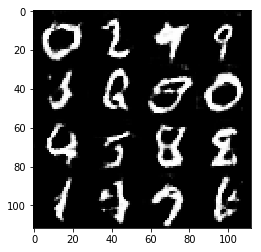

Epoch 2/2... Discriminator Loss: 0.5817... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 0.4885... Generator Loss: 1.2472
Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 9.7718... Generator Loss: 0.0001
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 2.1601
Epoch 2/2... Discriminator Loss: 0.3486... Generator Loss: 1.9173


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 1.9314
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 4.5579
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 4.0876
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 2.3292
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 0.9918


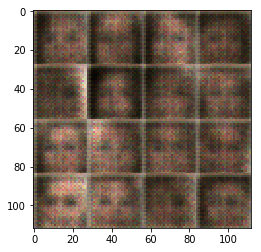

Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 2.0436
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 2.3221
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.8600
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.4448
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.2487


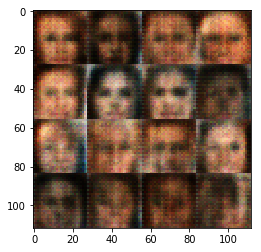

Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.7928
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 0.7738


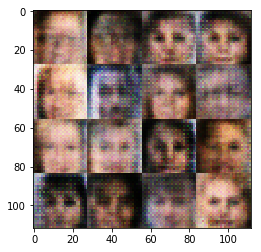

Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 1.7480
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.0760


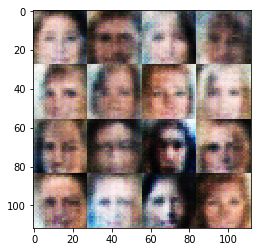

Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.4767
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.7410


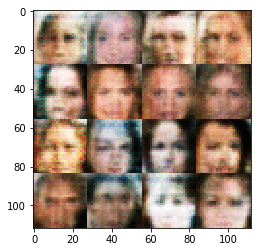

Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 0.2575
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.6550


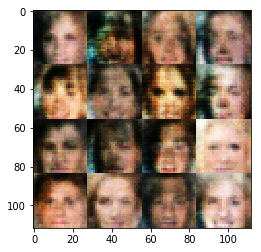

Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 2.3044
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.8115


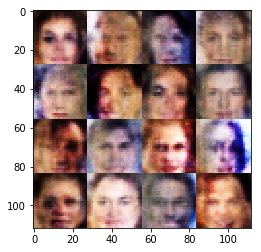

Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.4927
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.8940


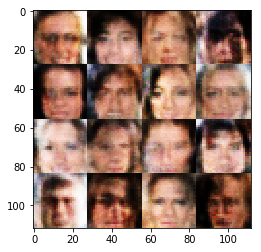

Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.7088


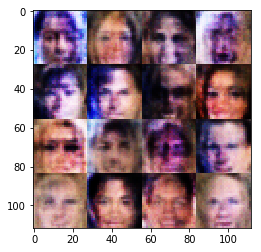

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.5539
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.6220


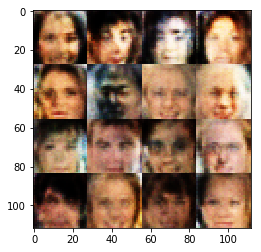

Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 2.6663
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.8516
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.6679


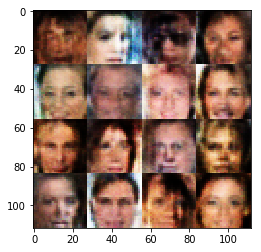

Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.8860
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 1.6133
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.6189


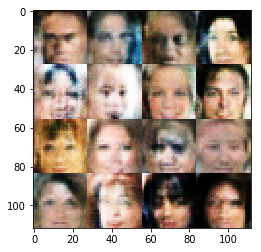

Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 2.1521
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.7365... Generator Loss: 0.2591
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.0732


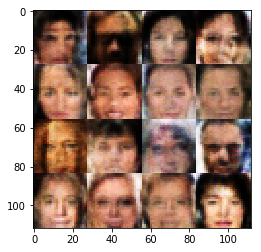

Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.5251
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.5471
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 2.8478
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 1.3445


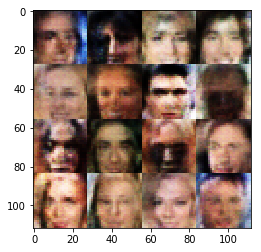

Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 1.7182
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 0.2978... Generator Loss: 2.9901
Epoch 1/1... Discriminator Loss: 0.4915... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 3.2110
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.5682
Epoch 1/1... Discriminator Loss: 0.2693... Generator Loss: 2.0504


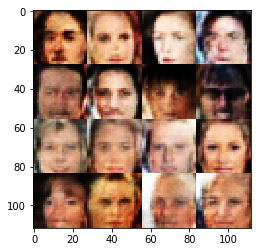

Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.3618
Epoch 1/1... Discriminator Loss: 1.8744... Generator Loss: 0.2223
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.5759
Epoch 1/1... Discriminator Loss: 0.2475... Generator Loss: 2.6111
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 5.7339
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 1.7472
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 4.9529
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 3.9850


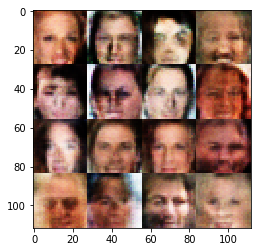

Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 0.2847... Generator Loss: 2.4034
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 4.7943
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 5.4533
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 3.0888
Epoch 1/1... Discriminator Loss: 2.1528... Generator Loss: 4.5215
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.6183
Epoch 1/1... Discriminator Loss: 0.6546... Generator Loss: 0.9241


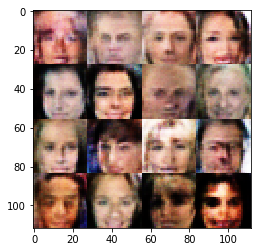

Epoch 1/1... Discriminator Loss: 0.2198... Generator Loss: 3.0807
Epoch 1/1... Discriminator Loss: 0.2107... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 6.1911
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 7.2670
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 0.3149... Generator Loss: 1.8491
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 0.8382


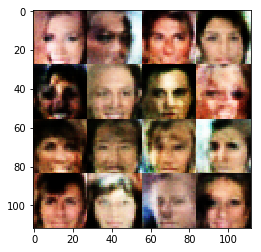

Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 7.0147
Epoch 1/1... Discriminator Loss: 2.0401... Generator Loss: 0.1878
Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 4.2266
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 2.1890
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 4.1697
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 3.1964
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 1.7256
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 4.0078
Epoch 1/1... Discriminator Loss: 0.1969... Generator Loss: 3.9733


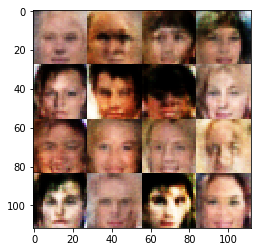

Epoch 1/1... Discriminator Loss: 0.2196... Generator Loss: 3.9184
Epoch 1/1... Discriminator Loss: 0.1826... Generator Loss: 2.9357
Epoch 1/1... Discriminator Loss: 0.1249... Generator Loss: 2.7002
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 4.6844
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.2147... Generator Loss: 4.5983
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 2.8796
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 0.0909... Generator Loss: 4.4245
Epoch 1/1... Discriminator Loss: 0.2822... Generator Loss: 1.8120


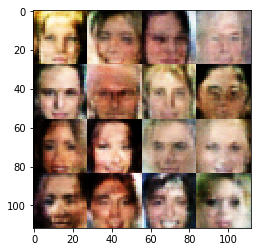

Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 4.9606
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 4.2663
Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 7.3884
Epoch 1/1... Discriminator Loss: 4.6244... Generator Loss: 5.6005
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 5.0836
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 4.4297
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 5.0279
Epoch 1/1... Discriminator Loss: 0.5289... Generator Loss: 6.8129
Epoch 1/1... Discriminator Loss: 0.3109... Generator Loss: 4.0563


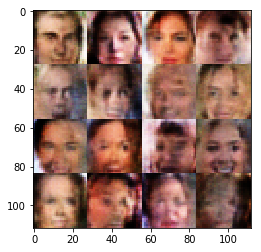

Epoch 1/1... Discriminator Loss: 0.2041... Generator Loss: 2.8688
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 1.8415
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 3.6682
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 1.3025
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 3.5093
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.5197
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 4.5813
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 0.3062... Generator Loss: 5.1001
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 5.5457


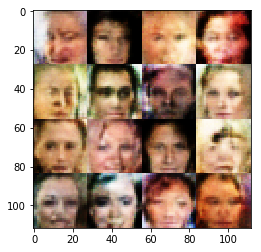

Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 3.1108
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 0.2551... Generator Loss: 2.0510
Epoch 1/1... Discriminator Loss: 0.2210... Generator Loss: 2.2611
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 5.0666
Epoch 1/1... Discriminator Loss: 0.1468... Generator Loss: 3.2044
Epoch 1/1... Discriminator Loss: 0.0771... Generator Loss: 4.6618
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.1388... Generator Loss: 2.9971
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.0664


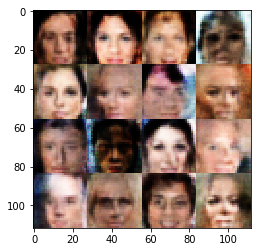

Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 5.9879
Epoch 1/1... Discriminator Loss: 1.7931... Generator Loss: 4.3278
Epoch 1/1... Discriminator Loss: 0.1181... Generator Loss: 3.8296
Epoch 1/1... Discriminator Loss: 0.2960... Generator Loss: 1.9472
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 4.1544
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 3.9095
Epoch 1/1... Discriminator Loss: 0.0756... Generator Loss: 4.0552
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 0.1341... Generator Loss: 2.7275


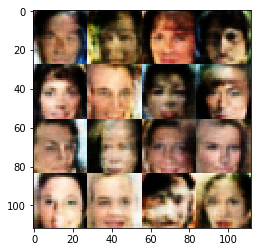

Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 4.0058
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 3.8876
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 3.8441
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 2.5077
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 0.0439... Generator Loss: 9.2620
Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 6.3581
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 2.3500... Generator Loss: 0.1274


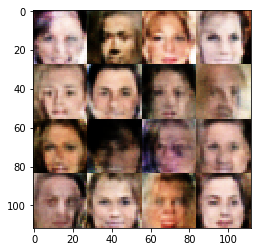

Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 4.5570
Epoch 1/1... Discriminator Loss: 0.1624... Generator Loss: 2.7200
Epoch 1/1... Discriminator Loss: 0.1259... Generator Loss: 5.2653
Epoch 1/1... Discriminator Loss: 0.1097... Generator Loss: 4.5592
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 2.6865
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 3.3578
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 6.0406
Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 4.3441
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 1.7837


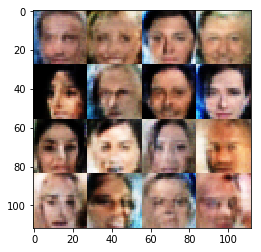

Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 3.9570
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 4.0240
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 7.1547
Epoch 1/1... Discriminator Loss: 0.0990... Generator Loss: 5.3228
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 4.6197
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 7.2453
Epoch 1/1... Discriminator Loss: 0.0702... Generator Loss: 5.5786
Epoch 1/1... Discriminator Loss: 0.0398... Generator Loss: 4.5131
Epoch 1/1... Discriminator Loss: 0.0900... Generator Loss: 3.5577


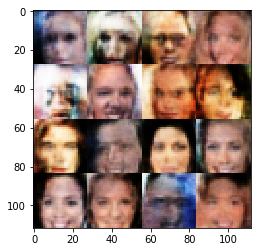

Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 5.2794
Epoch 1/1... Discriminator Loss: 0.0967... Generator Loss: 3.2916
Epoch 1/1... Discriminator Loss: 0.1551... Generator Loss: 2.3670
Epoch 1/1... Discriminator Loss: 0.0980... Generator Loss: 3.2152
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 6.0191
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 6.7685
Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 6.4340
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.4480


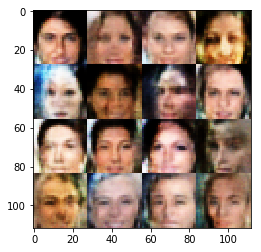

Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.7512
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 0.0857... Generator Loss: 2.9991
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.1022... Generator Loss: 3.3285
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 5.4008
Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 5.9391
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 3.8946
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 2.9083


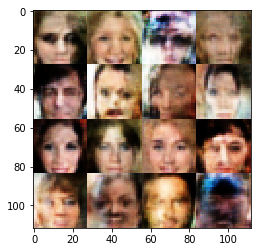

Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 4.2449
Epoch 1/1... Discriminator Loss: 0.2041... Generator Loss: 4.0642
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 7.1962
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 3.2963
Epoch 1/1... Discriminator Loss: 0.1307... Generator Loss: 2.7908
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 0.1147... Generator Loss: 5.3912
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 4.0295
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 3.2796
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 5.4342


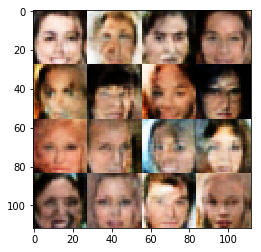

Epoch 1/1... Discriminator Loss: 0.0852... Generator Loss: 6.5220
Epoch 1/1... Discriminator Loss: 0.1187... Generator Loss: 6.2048
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 6.5918
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 9.4959
Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 7.0354
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 5.2314
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 0.2010... Generator Loss: 8.4181
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 6.0826
Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 0.2886


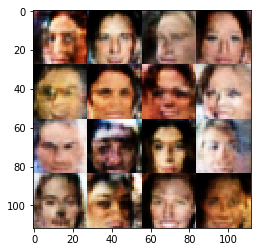

Epoch 1/1... Discriminator Loss: 0.2127... Generator Loss: 2.7450
Epoch 1/1... Discriminator Loss: 0.0822... Generator Loss: 6.0895
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 0.2476... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 2.5812
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 5.0510


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.